In [57]:
import genius_utils as gu
import spotify_utils as su
import numpy as np
from sentence_transformers import SentenceTransformer
from pprint import pprint
import re
import os
import pickle
import matplotlib.pyplot as plt

In [40]:
playlist = su.get_playlist('https://open.spotify.com/playlist/11OS4z2v9GRjyA6Q5KFu0c?si=7acc108a7c7041ff')

In [41]:
playlist

{'29 #Strafford APTS': 'Bon Iver',
 'Somebody That I Used To Know': 'Elliott Smith',
 'For Emma': 'Bon Iver',
 'Re: Stacks': 'Bon Iver',
 'Everything Means Nothing To Me': 'Elliott Smith',
 'Landslide': 'Fleetwood Mac',
 'Gold Day': 'Sparklehorse',
 'By This River': 'Brian Eno',
 'Everything Reminds Me Of Her': 'Elliott Smith',
 "I'm So Tired": 'Fugazi',
 'Skeleton Tree': 'Nick Cave & The Bad Seeds',
 "King's Crossing": 'Elliott Smith',
 'Casimir Pulaski Day': 'Sufjan Stevens',
 'Waltz #2 (XO)': 'Elliott Smith',
 'John Wayne Gacy, Jr.': 'Sufjan Stevens',
 'Gagging Order': 'Radiohead',
 'The Moon': 'The Microphones',
 'I Felt My Size': 'The Microphones',
 'Death with Dignity': 'Sufjan Stevens',
 'Katy Song': 'Red House Painters',
 'Ravens': 'Mount Eerie',
 "I Can't Give Everything Away": 'David Bowie',
 "I Can't Believe You Actually Died": 'The Microphones',
 'Come Softly - For Daniel D.': 'Grouper',
 'Glass Eyes': 'Radiohead',
 'I Will Follow You into the Dark': 'Death Cab for Cutie',


In [42]:
positive_words = ['joy', 'love', 'cheerful', 'delight', 'hope', 'smile', 'excited']
negative_words = ['pain', 'hate', 'sadness', 'grief', 'anger', 'cry', 'depressed']

In [64]:
positive_phrases = ['I\'m so happy', 'dancing in the sunlight', 'life is beautiful', 'nothing can stop me', 'hearts wide open', 'floating in love', 'everthing is alright', 'holding your hand']
negative_phrases = ['I can\'t go on', 'everything hurts', 'heart shattered', 'I miss you so much', 'I\'m so lonely', 'this pain won\'t end', 'my soul is tired', 'wishing you were here', 'broken and bruised']

In [43]:
def normalize(v):
    return v / np.linalg.norm(v)

In [44]:
def compute_axis(pos_words, neg_words, model = SentenceTransformer('all-MiniLM-L6-v2')):
    pos_vecs = model.encode(pos_words)
    neg_vecs = model.encode(neg_words)

    pos_vecs = [normalize(v) for v in pos_vecs]
    neg_vecs = [normalize(v) for v in neg_vecs]
    
    return np.mean(pos_vecs, axis = 0) - np.mean(neg_vecs, axis = 0)

In [45]:
def project_line(line, axis, model = SentenceTransformer('all-MiniLM-L6-v2')):
    line_vec = normalize(model.encode(line))
    return np.dot(line_vec, axis)

In [46]:
def score_song(song, axis, model = SentenceTransformer('all-MiniLM-L6-v2')):
    lines = gu.lyrics_preprocessing(song.lyrics)
    scores = [project_line(line, axis, model) for line in lines]
    return np.mean(scores), scores

In [53]:
def score_playlist(playlist, axis, model = SentenceTransformer('all-MiniLM-L6-v2')):
    score_d = {}
    for song_name in playlist.keys():
        try:
            artist_name = playlist[song_name]
            song = gu.get_song(song_name, artist_name)
            if not song or not hasattr(song, 'lyrics') or not song.lyrics:
                print(f"Skipping '{song_name}' by {artist_name} — no lyrics found.")
                continue

            score, _ = score_song(song, axis, model)
            score_d[f"{song_name} — {artist_name}"] = score

        except Exception as e:
            print(f"Error scoring '{song_name}' by {artist_name}: {e}")
            continue

    return score_d
        

In [54]:
emotion_axis = compute_axis(positive_words, negative_words)

In [55]:
scores = score_playlist(playlist, emotion_axis)

Searching for "29 #Strafford APTS" by Bon Iver...
Done.
Searching for "Somebody That I Used To Know" by Elliott Smith...
Done.
Searching for "For Emma" by Bon Iver...
Done.
Searching for "Re: Stacks" by Bon Iver...
Done.
Searching for "Everything Means Nothing To Me" by Elliott Smith...
Done.
Searching for "Landslide" by Fleetwood Mac...
Done.
Searching for "Gold Day" by Sparklehorse...
Done.
Searching for "By This River" by Brian Eno...
Done.
Searching for "Everything Reminds Me Of Her" by Elliott Smith...
Done.
Searching for "I'm So Tired" by Fugazi...
Done.
Searching for "Skeleton Tree" by Nick Cave & The Bad Seeds...
Done.
Searching for "King's Crossing" by Elliott Smith...
Done.
Searching for "Casimir Pulaski Day" by Sufjan Stevens...
Done.
Searching for "Waltz #2 (XO)" by Elliott Smith...
Done.
Searching for "John Wayne Gacy, Jr." by Sufjan Stevens...
Done.
Searching for "Gagging Order" by Radiohead...
Done.
Searching for "The Moon" by The Microphones...
Done.
Searching for "I Fe

In [56]:
scores

{'29 #Strafford APTS — Bon Iver': np.float32(-0.0074599786),
 'Somebody That I Used To Know — Elliott Smith': np.float32(-0.035096146),
 'For Emma — Bon Iver': np.float32(-0.0013777881),
 'Re: Stacks — Bon Iver': np.float32(-0.008219402),
 'Everything Means Nothing To Me — Elliott Smith': np.float32(-0.008218987),
 'Landslide — Fleetwood Mac': np.float32(-0.0150865475),
 'Gold Day — Sparklehorse': np.float32(0.008864056),
 'By This River — Brian Eno': np.float32(0.00955389),
 'Everything Reminds Me Of Her — Elliott Smith': np.float32(-0.03627871),
 "I'm So Tired — Fugazi": np.float32(-0.043903932),
 'Skeleton Tree — Nick Cave & The Bad Seeds': np.float32(0.0014723212),
 "King's Crossing — Elliott Smith": np.float32(-0.008843108),
 'Casimir Pulaski Day — Sufjan Stevens': np.float32(0.005582283),
 'Waltz #2 (XO) — Elliott Smith': np.float32(-0.0060574138),
 'John Wayne Gacy, Jr. — Sufjan Stevens': np.float32(-0.0011684475),
 'Gagging Order — Radiohead': np.float32(-0.018154103),
 'The Mo

In [66]:
phrase_axis = compute_axis(positive_phrases, negative_phrases)

In [67]:
phrase_scores = score_playlist(playlist, phrase_axis)

Searching for "29 #Strafford APTS" by Bon Iver...


/Users/dominicbankovitch/Documents/Repos/music-sentiment/venv/lib/python3.13/site-packages/lyricsgenius/genius.py:468: FutureWarning: The constructor signature will change in a future version. It will change to Song(lyrics, body) instead of Song(client, json_dict, lyrics).
  song = Song(self, song_info, lyrics)


Done.
Searching for "Somebody That I Used To Know" by Elliott Smith...
Done.
Searching for "For Emma" by Bon Iver...
Done.
Searching for "Re: Stacks" by Bon Iver...
Done.
Searching for "Everything Means Nothing To Me" by Elliott Smith...
Done.
Searching for "Landslide" by Fleetwood Mac...
Done.
Searching for "Gold Day" by Sparklehorse...
Done.
Searching for "By This River" by Brian Eno...
Done.
Searching for "Everything Reminds Me Of Her" by Elliott Smith...
Done.
Searching for "I'm So Tired" by Fugazi...
Done.
Searching for "Skeleton Tree" by Nick Cave & The Bad Seeds...
Done.
Searching for "King's Crossing" by Elliott Smith...
Done.
Searching for "Casimir Pulaski Day" by Sufjan Stevens...
Done.
Searching for "Waltz #2 (XO)" by Elliott Smith...
Done.
Searching for "John Wayne Gacy, Jr." by Sufjan Stevens...
Done.
Searching for "Gagging Order" by Radiohead...
Done.
Searching for "The Moon" by The Microphones...
Done.
Searching for "I Felt My Size" by The Microphones...
Done.
Searching 

In [62]:
def plot_song_scores(scores_dict, axis_name = "Sentiment Axis [-1, 1]"):
    songs = list(scores_dict.keys())
    scores = list(scores_dict.values())

    plt.figure(figsize=(10, len(songs) * 0.4))

    plt.scatter(scores, range(len(songs)), color = 'dodgerblue')

    for i, song in enumerate(songs):
        plt.text(scores[i], i, song, va='center', ha='left' if scores[i] < 0 else 'right')

    plt.yticks([])
    plt.xlabel(axis_name)
    plt.title("Songs Positioned on 1D Sentiment Axis")
    plt.tight_layout()
    plt.grid(True, axis='x', linestyle=':', alpha=0.5)
    plt.show()
    

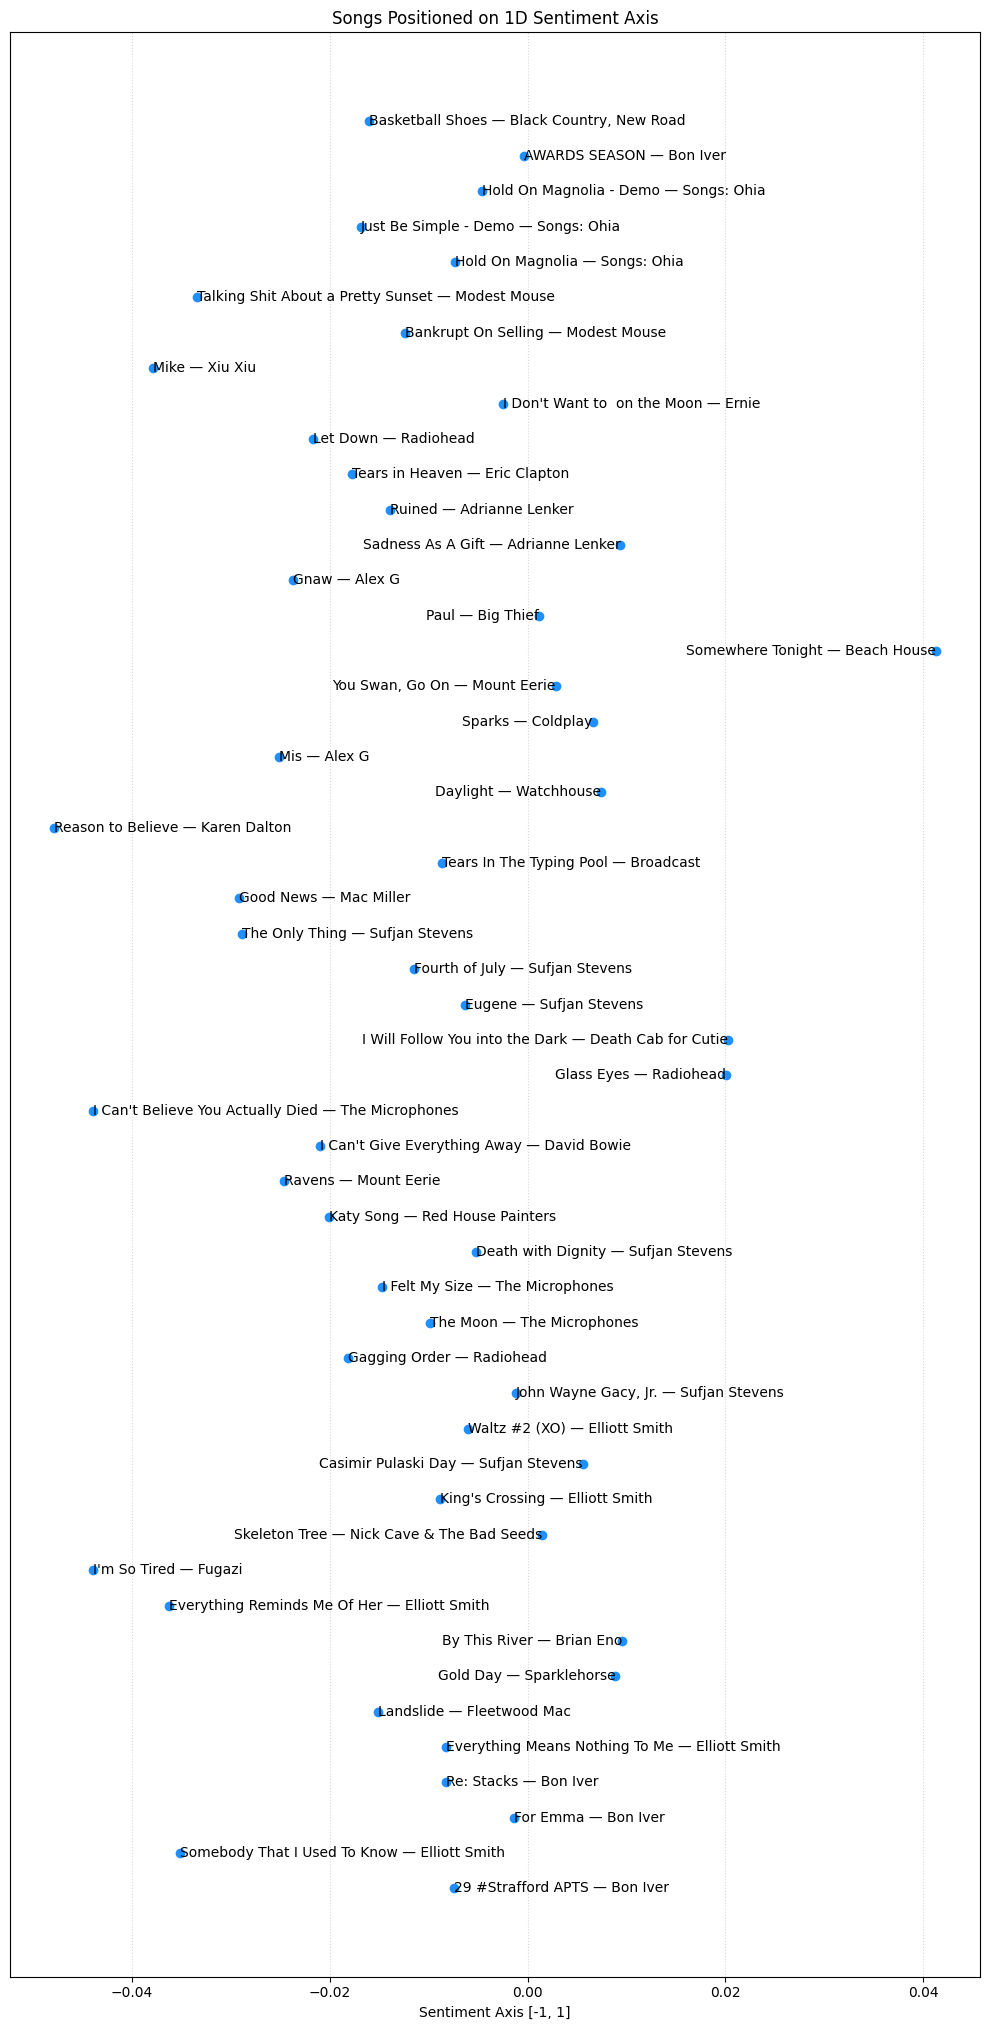

In [63]:
plot_song_scores(scores)

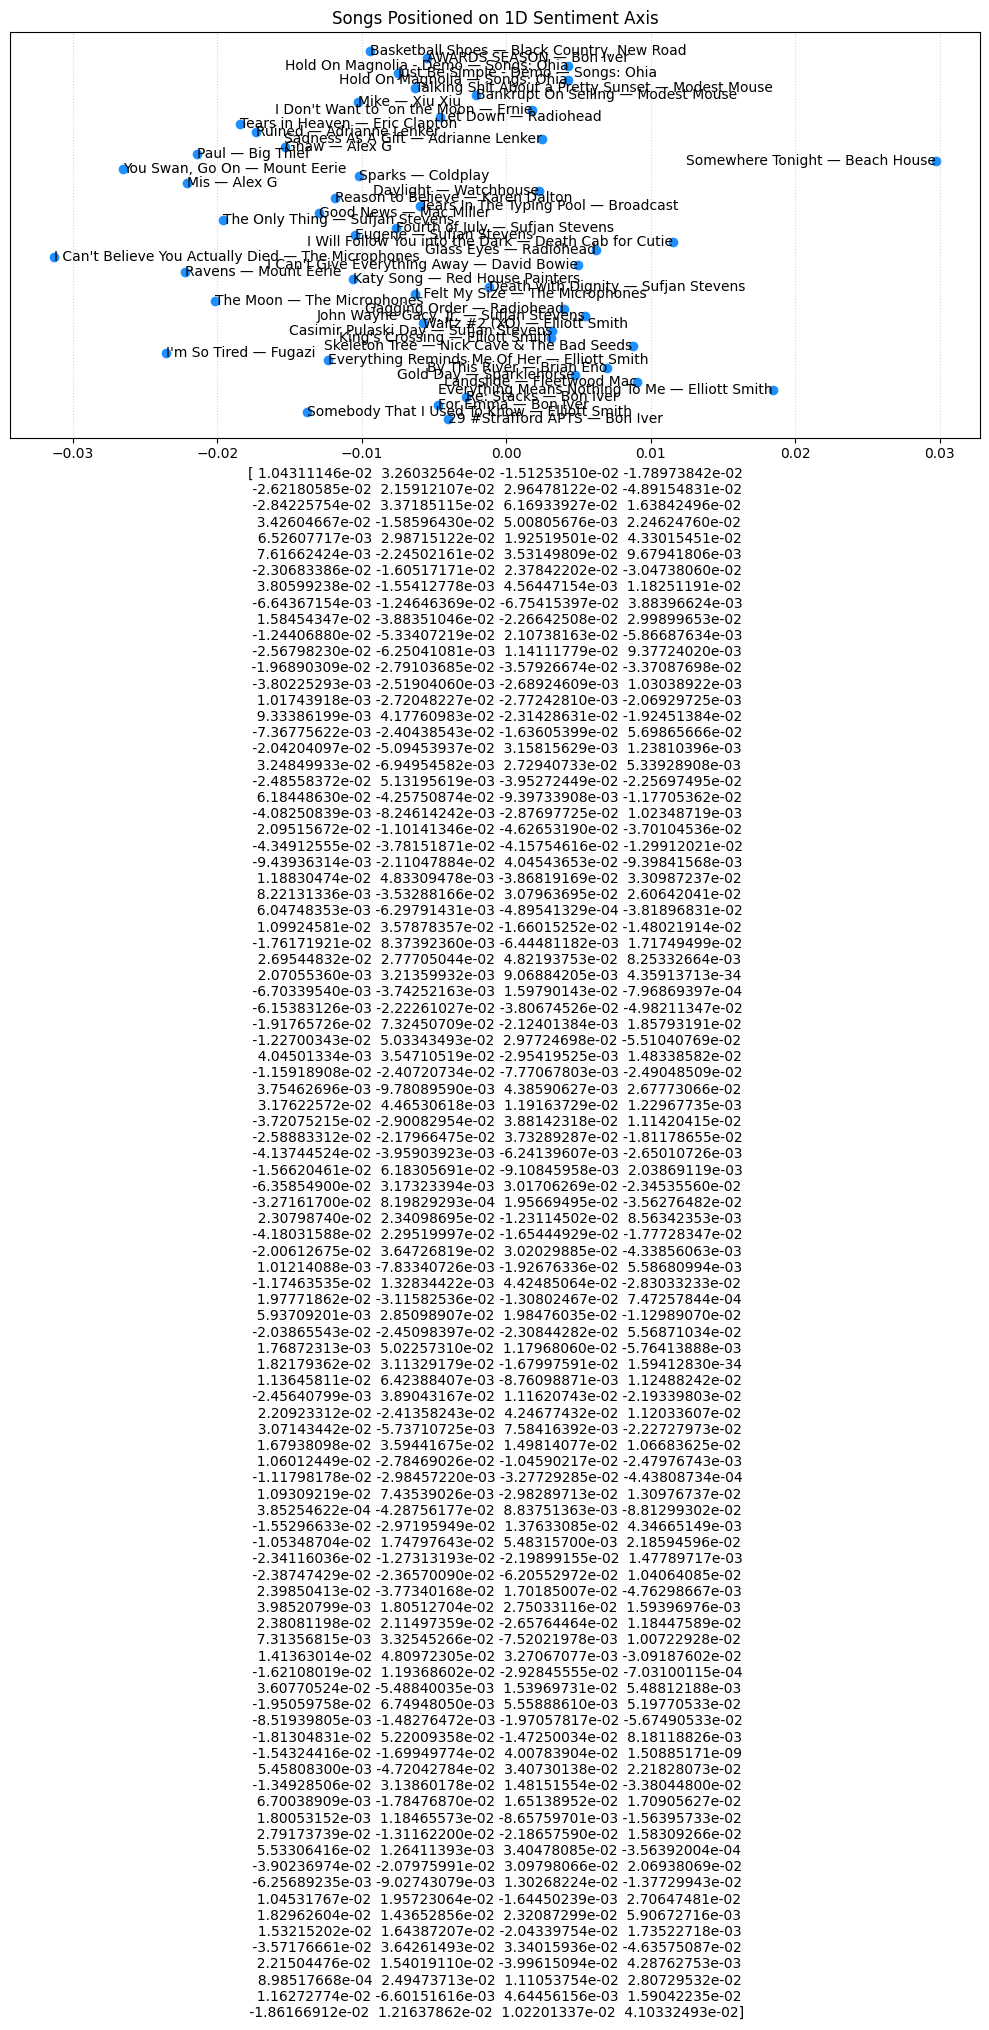

In [68]:
plot_song_scores(phrase_scores, phrase_axis)